<a href="https://colab.research.google.com/github/Jiacheng1216/Tensorflow2.0/blob/master/LAB9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from preprocessing import flip, color, rotate, zoom

In [ ]:
train_split, valid_split, test_split = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']
train_data, info = tfds.load("cats_vs_dogs", split=train_split, with_info=True)
valid_data = tfds.load("cats_vs_dogs", split=valid_split)
test_data = tfds.load("cats_vs_dogs", split=test_split)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteDLWVKJ/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [ ]:
print(info.features['label'].names)
decoder = info.features['label'].names

['cat', 'dog']


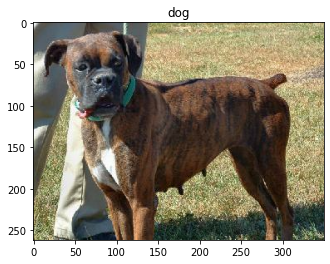

In [ ]:
for data in train_data.take(1):
    img = data['image']
    label = data['label']
plt.title(decoder[label])
plt.imshow(img)

In [ ]:
input_shape = (299, 299)

In [ ]:
def parse_aug_fn(dataset):
    x = tf.cast(dataset['image'], tf.float32) / 255.  
    x = tf.image.resize(x, input_shape)
    x = flip(x)  
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: color(x), lambda: x)
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.75, lambda: rotate(x), lambda: x)
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: zoom(x), lambda: x)
    return x, dataset['label']

def parse_fn(dataset):
    x = tf.cast(dataset['image'], tf.float32) 
    x = tf.image.resize(x, input_shape)
    return x, dataset['label']

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  
buffer_size = 1000  
bacth_size = 32  

train_data = train_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
train_data = train_data.shuffle(buffer_size) 
train_data = train_data.batch(bacth_size).prefetch(buffer_size=AUTOTUNE)

valid_data = valid_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
valid_data = valid_data.batch(bacth_size).prefetch(buffer_size=AUTOTUNE)

test_data = test_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(bacth_size).prefetch(buffer_size=AUTOTUNE)

In [ ]:
model_dir = 'lab9-logs/models' 
os.makedirs(model_dir) 

In [ ]:
log_dir = os.path.join('lab9-logs', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.h5', 
                                             monitor='val_binary_accuracy', 
                                             save_best_only=True, 
                                             mode='max')
model_esp = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=20)

In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False, 
                                               weights=None, 
                                               pooling='avg', 
                                               input_shape=input_shape+(3,))

model_1 = tf.keras.Sequential([
    base_model,
    layers.Dense(128, activation='relu'), 
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 22,065,185
Trainable params: 22,030,753
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
model_1.compile(keras.optimizers.Adam(), 
                loss=keras.losses.BinaryCrossentropy(), 
                metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
history = model_1.fit(train_data,
                      epochs=200, 
                      validation_data=valid_data,
                      callbacks=[model_cbk, model_mckp, model_esp])

Epoch 1/200
582/582 [==============================] - 165s 254ms/step - loss: 0.6800 - binary_accuracy: 0.5890 - val_loss: 7.2147 - val_binary_accuracy: 0.4815
Epoch 2/200
582/582 [==============================] - 148s 250ms/step - loss: 0.6204 - binary_accuracy: 0.6490 - val_loss: 144.1193 - val_binary_accuracy: 0.4837
Epoch 3/200
582/582 [==============================] - 147s 248ms/step - loss: 0.5543 - binary_accuracy: 0.7120 - val_loss: 78.3775 - val_binary_accuracy: 0.4815
Epoch 4/200
582/582 [==============================] - 147s 248ms/step - loss: 0.4784 - binary_accuracy: 0.7679 - val_loss: 107.7044 - val_binary_accuracy: 0.4815
Epoch 5/200
582/582 [==============================] - 147s 248ms/step - loss: 0.4089 - binary_accuracy: 0.8120 - val_loss: 57.7292 - val_binary_accuracy: 0.4815
Epoch 6/200
582/582 [==============================] - 146s 248ms/step - loss: 0.3440 - binary_accuracy: 0.8477 - val_loss: 97.2749 - val_binary_accuracy: 0.4815
Epoch 7/200
582/582 [======

In [ ]:
log_dir = os.path.join('lab9-logs', 'model-2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-2.h5', 
                                             monitor='val_binary_accuracy', 
                                             save_best_only=True, 
                                             mode='max')
model_esp = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=20, mode='max')

In [ ]:
module_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

model_2 = tf.keras.Sequential([
    hub.KerasLayer(module_url,
                   input_shape=(299, 299, 3),  
                   output_shape=(2048,),  
                   trainable=False), 
    layers.Dense(128, activation='relu'), 
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 22,065,185
Trainable params: 262,401
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model_2.compile(keras.optimizers.Adam(), 
               loss=keras.losses.BinaryCrossentropy(), 
               metrics=[keras.metrics.BinaryAccuracy()])

In [18]:
history = model_2.fit(train_data,
                      epochs=200, 
                      validation_data=valid_data,
                      callbacks=[model_cbk, model_esp, model_mckp])

Epoch 1/200
582/582 [==============================] - 58s 88ms/step - loss: 0.0793 - binary_accuracy: 0.9717 - val_loss: 51.9290 - val_binary_accuracy: 0.5077
Epoch 2/200
582/582 [==============================] - 52s 86ms/step - loss: 0.0574 - binary_accuracy: 0.9804 - val_loss: 105.1887 - val_binary_accuracy: 0.4858
Epoch 3/200
582/582 [==============================] - 53s 87ms/step - loss: 0.0499 - binary_accuracy: 0.9819 - val_loss: 83.6196 - val_binary_accuracy: 0.4837
Epoch 4/200
582/582 [==============================] - 53s 87ms/step - loss: 0.0489 - binary_accuracy: 0.9813 - val_loss: 77.5170 - val_binary_accuracy: 0.4893
Epoch 5/200
582/582 [==============================] - 53s 87ms/step - loss: 0.0507 - binary_accuracy: 0.9808 - val_loss: 105.8303 - val_binary_accuracy: 0.4862
Epoch 6/200
582/582 [==============================] - 53s 87ms/step - loss: 0.0503 - binary_accuracy: 0.9819 - val_loss: 66.4068 - val_binary_accuracy: 0.5052
Epoch 7/200
582/582 [=================

In [19]:
model_1.load_weights(model_dir + '/Best-model-1.h5')
model_2.load_weights(model_dir + '/Best-model-2.h5')

In [20]:
loss_1, acc_1 = model_1.evaluate(test_data)
loss_2, acc_2 = model_2.evaluate(test_data)

73/73 [==============================] - 5s 69ms/step - loss: 95.4155 - binary_accuracy: 0.5348


In [21]:
print("Model_1 Prediction: {}%".format(acc_1 * 100))
print("Model_2 Prediction: {}%".format(acc_2 * 100))

Model_1 Prediction: 64.18744921684265%
Model_2 Prediction: 53.48237156867981%


In [22]:
acc_2 - acc_1

-0.10705077648162842